In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seysmo.models.model_class import CNN, CNNLSTMNetwork
from seysmo.models.train_model import train, evaluate
from seysmo.models.utils import save_model, load_model, count_parameters, EarlyStopper, SignalSpeedDataset
from seysmo.visualization.plotting import plot_map
from seysmo.features.mapping import do_array_for_mapping, compute_y_pred
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import MeanAbsolutePercentageError

import mlflow

mlflow.set_tracking_uri("http://localhost:5000")

In [2]:
import pickle

with open('../data/processed/coord_dict.pkl', 'rb') as f:
    data_coord = pickle.load(f)

In [3]:
coordinates = list(data_coord.keys())
sorted_coordinates = sorted(coordinates, key=lambda x: x[1])
sorted_array = np.array(sorted_coordinates)
coord_train = sorted_array[::3]

In [4]:
X_train = []
y_train = []
for key in coord_train:
    X_train.append(data_coord[tuple(key.tolist())][0])
    y_train.append(data_coord[tuple(key.tolist())][1])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [5]:
X_train.shape

(11045, 33, 438)

In [6]:
X_val = []
y_val = []
coord_val = sorted_array[1::3]
coord_test = sorted_array[2::3]
for key in coord_val:
    X_val.append(data_coord[tuple(key.tolist())][0])
    y_val.append(data_coord[tuple(key.tolist())][1])
X_val = np.array(X_val)
y_val = np.array(y_val)

In [7]:
X_test = []
y_test = []
for key in coord_test:
    X_test.append(data_coord[tuple(key.tolist())][0])
    y_test.append(data_coord[tuple(key.tolist())][1])
X_test = np.array(X_test)
y_test = np.array(y_test)

In [23]:
# TODO случайный выбор валидации. Аккуратно с их координатами
X_vt = np.concatenate([X_val, X_test])
y_vt = np.concatenate([y_val, y_test])
coord_vt = np.concatenate([coord_val, coord_test])
X_test, X_val, coord_test, coord_val = X_vt[:int(len(X_vt) * 0.95)], X_vt[int(len(X_vt) * 0.95):], coord_vt[:int(
    len(X_vt) * 0.95)], coord_vt[int(len(X_vt) * 0.95):]
y_test, y_val = y_vt[:int(len(X_vt) * 0.95)], y_vt[int(len(X_vt) * 0.95):]
print(X_val.shape)
print(X_test.shape)
print(coord_val.shape)
print(coord_test.shape)

(1105, 33, 438)
(20983, 33, 438)
(1105, 2)
(20983, 2)


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = 1
out_channels = 16
conv_kernel_size = 5
stride = 2
padding = 1
hidden_size = 128
num_layers = 2
dropout = 0.2
linear_input_size = 64
linear_output_size = 1
input_shape = X_train[0].shape
epochs = 70
batch_size = 32
learning_rate = 0.001
patience = 3
min_delta = 40
loss_fn = nn.MSELoss()
metric_fn = MeanAbsolutePercentageError().to(device)
model0 = CNNLSTMNetwork(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_kernel_size, stride=stride,
                        padding=padding, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout,
                        linear_input_size=linear_input_size, linear_output_size=linear_output_size,
                        input_shape=input_shape).to(device)
early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)
optimizer = torch.optim.Adam(model0.parameters(), lr=learning_rate)

In [25]:
train_dataset = SignalSpeedDataset(X_train, y_train[:, 0])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SignalSpeedDataset(X_val, y_val[:, 0])
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SignalSpeedDataset(X_test, y_test[:, 0])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
mlflow.set_experiment("/CNNLSTM_one_depth")

<Experiment: artifact_location='mlflow-artifacts:/306227180843750601', creation_time=1722086323601, experiment_id='306227180843750601', last_update_time=1722086323601, lifecycle_stage='active', name='/CNNLSTM_one_depth', tags={}>

In [27]:
with mlflow.start_run(run_name='first_depth') as run:
    params = {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": "ADAM",
        "in_channels": in_channels,
        'out_channels': out_channels,
        "conv_kernel_size": conv_kernel_size,
        'stride': stride,
        'padding': padding,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
        'linear_input_size': linear_input_size,
        'linear_output_size': linear_output_size,
        "input_shape": input_shape,
        'patience': patience,
        'min_delta': min_delta
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("../models/model_P_summary.txt", "w", encoding="utf-8") as f:
        f.write(str(summary(model0)))
    mlflow.log_artifact("../models/model_P_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        train(train_dataloader, model0, loss_fn, metric_fn, optimizer, epoch=t, device=device,
              output_size=linear_output_size)
        validation_loss, validation_mape = evaluate(val_dataloader, model0, loss_fn, metric_fn, epoch=t, device=device,
                                                    output_size=linear_output_size)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model0, "model")

Epoch 1
-------------------------------
loss: 51772.132812 MAPE: 0.999523 [0 / 346]
loss: 22817.843750 MAPE: 0.615047 [100 / 346]
loss: 944.030273 MAPE: 0.119440 [200 / 346]
loss: 1375.758911 MAPE: 0.151687 [300 / 346]
Eval metrics: 
MAPE: 0.13, Avg loss: 1239.559913 

Epoch 2
-------------------------------
loss: 1347.886475 MAPE: 0.142095 [0 / 346]
loss: 766.295776 MAPE: 0.107102 [100 / 346]
loss: 1438.137207 MAPE: 0.151008 [200 / 346]
loss: 1254.137451 MAPE: 0.131867 [300 / 346]
Eval metrics: 
MAPE: 0.13, Avg loss: 1234.410277 

Epoch 3
-------------------------------
loss: 1134.852295 MAPE: 0.125479 [0 / 346]
loss: 635.815186 MAPE: 0.077034 [100 / 346]
loss: 640.599121 MAPE: 0.096995 [200 / 346]
loss: 448.463928 MAPE: 0.071228 [300 / 346]
Eval metrics: 
MAPE: 0.16, Avg loss: 1921.542857 

Epoch 4
-------------------------------
loss: 542.612427 MAPE: 0.077050 [0 / 346]
loss: 346.666534 MAPE: 0.066928 [100 / 346]
loss: 596.962036 MAPE: 0.090891 [200 / 346]
loss: 356.726257 MAPE: 0.0

2024/07/27 18:00:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/07/27 18:00:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [28]:
num_batches = len(test_dataloader)
eval_loss, eval_mape = 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model0(X)
        eval_loss += loss_fn(torch.reshape(pred, (-1, 1)), torch.reshape(y, (-1, 1))).item()
        eval_mape += metric_fn(torch.reshape(pred, (-1, 1)), torch.reshape(pred, (-1, 1))).item()

eval_loss /= num_batches
eval_mape /= num_batches
print(f"Test loss: {eval_loss:4f}")
print(f"Test MAPE: {eval_mape:4f}")

Test loss: 1704.523609
Test MAPE: 0.000000


In [29]:
true_slice = do_array_for_mapping(coord_train, coord_val, coord_test, y_train[:, 0], y_val[:, 0], y_test[:, 0])
y_pred = compute_y_pred(model0, test_dataloader, 'cuda')
pred_slice = do_array_for_mapping(coord_train, coord_val, coord_test, y_train[:, 0], y_val[:, 0], y_pred)

[]

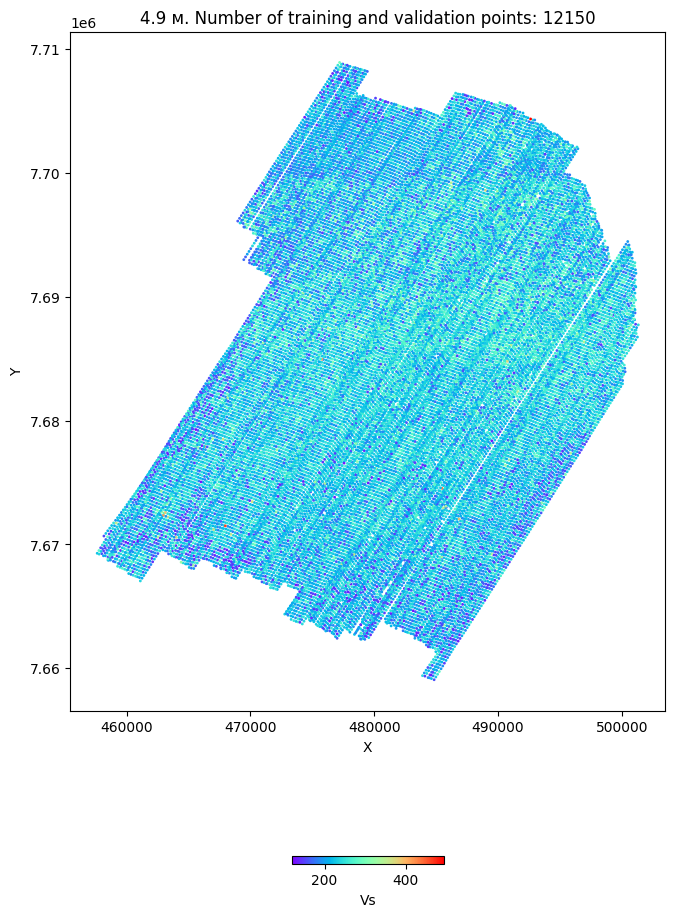

In [30]:
true_map = plot_map(true_slice, "4.9", X_train.shape[0], X_val.shape[0])
true_map.plot()

[]

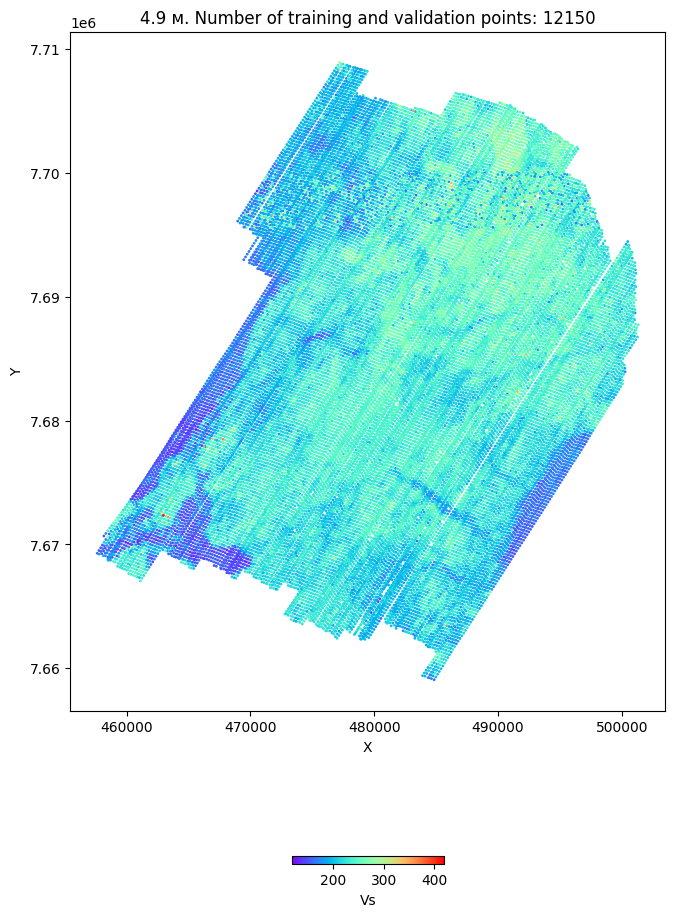

In [31]:
pred_map = plot_map(pred_slice, "4.9", X_train.shape[0], X_val.shape[0])
pred_map.plot()

In [32]:
train_dataset = SignalSpeedDataset(X_train, y_train[:, 1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SignalSpeedDataset(X_val, y_val[:, 1])
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SignalSpeedDataset(X_test, y_test[:, 1])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model1 = CNNLSTMNetwork(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_kernel_size, stride=stride,
                        padding=padding, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout,
                        linear_input_size=linear_input_size, linear_output_size=linear_output_size,
                        input_shape=input_shape).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

In [33]:
with mlflow.start_run(run_name=' second_depth') as run:
    params = {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": "ADAM",
        "in_channels": in_channels,
        'out_channels': out_channels,
        "conv_kernel_size": conv_kernel_size,
        'stride': stride,
        'padding': padding,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
        'linear_input_size': linear_input_size,
        'linear_output_size': linear_output_size,
        "input_shape": input_shape,
        'patience': patience,
        'min_delta': min_delta
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("../models/model_P_summary.txt", "w", encoding="utf-8") as f:
        f.write(str(summary(model1)))
    mlflow.log_artifact("../models/model_P_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        train(train_dataloader, model1, loss_fn, metric_fn, optimizer, epoch=t, device=device,
              output_size=linear_output_size)
        validation_loss, validation_mape = evaluate(val_dataloader, model1, loss_fn, metric_fn, epoch=t, device=device,
                                                    output_size=linear_output_size)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model1, "model")

Epoch 1
-------------------------------
loss: 42988.582031 MAPE: 1.000169 [0 / 346]
loss: 21149.152344 MAPE: 0.703474 [100 / 346]
loss: 2332.213867 MAPE: 0.201810 [200 / 346]
loss: 1297.482788 MAPE: 0.119158 [300 / 346]
Eval metrics: 
MAPE: 0.10, Avg loss: 626.003353 

Epoch 2
-------------------------------
loss: 590.345459 MAPE: 0.095909 [0 / 346]
loss: 466.817047 MAPE: 0.089518 [100 / 346]
loss: 608.019897 MAPE: 0.100529 [200 / 346]
loss: 671.156128 MAPE: 0.102868 [300 / 346]
Eval metrics: 
MAPE: 0.10, Avg loss: 630.753716 

Epoch 3
-------------------------------
loss: 375.488831 MAPE: 0.077867 [0 / 346]
loss: 351.716431 MAPE: 0.075287 [100 / 346]
loss: 573.674194 MAPE: 0.093991 [200 / 346]
loss: 437.290527 MAPE: 0.087648 [300 / 346]
Eval metrics: 
MAPE: 0.10, Avg loss: 637.032087 

Epoch 4
-------------------------------
loss: 545.337524 MAPE: 0.093363 [0 / 346]
loss: 931.479980 MAPE: 0.074908 [100 / 346]
loss: 152.896851 MAPE: 0.045579 [200 / 346]
loss: 116.701263 MAPE: 0.036743 

2024/07/27 18:11:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Eval metrics: 
MAPE: 0.13, Avg loss: 1164.101531 


2024/07/27 18:11:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [34]:
true_slice = do_array_for_mapping(coord_train, coord_val, coord_test, y_train[:, 1], y_val[:, 1], y_test[:, 1])
y_pred = compute_y_pred(model0, test_dataloader, 'cuda')
pred_slice = do_array_for_mapping(coord_train, coord_val, coord_test, y_train[:, 1], y_val[:, 1], y_pred)

[]

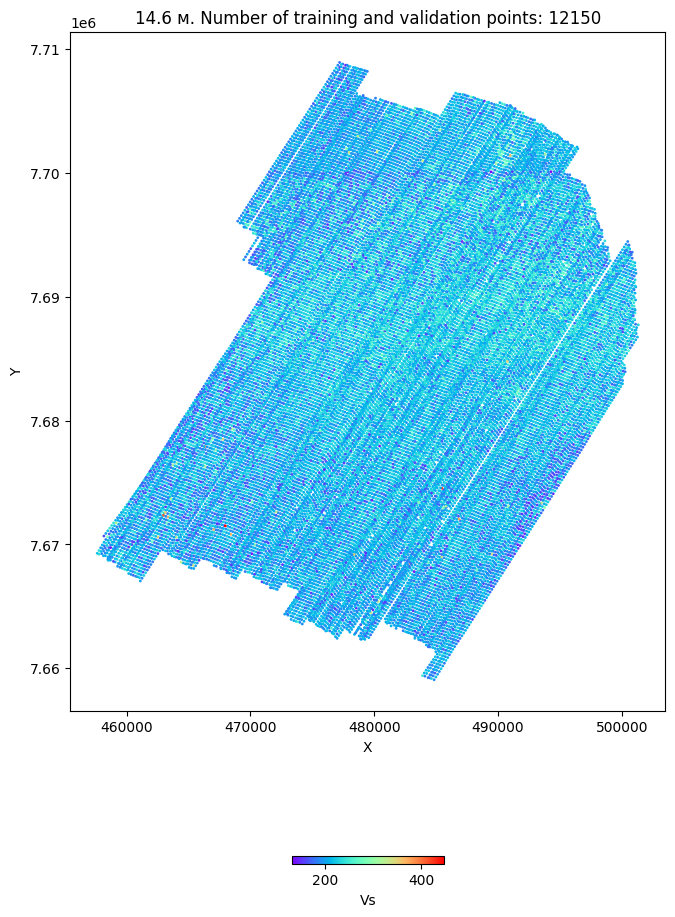

In [35]:
true_map = plot_map(true_slice, "14.6", X_train.shape[0], X_val.shape[0])
true_map.plot()

[]

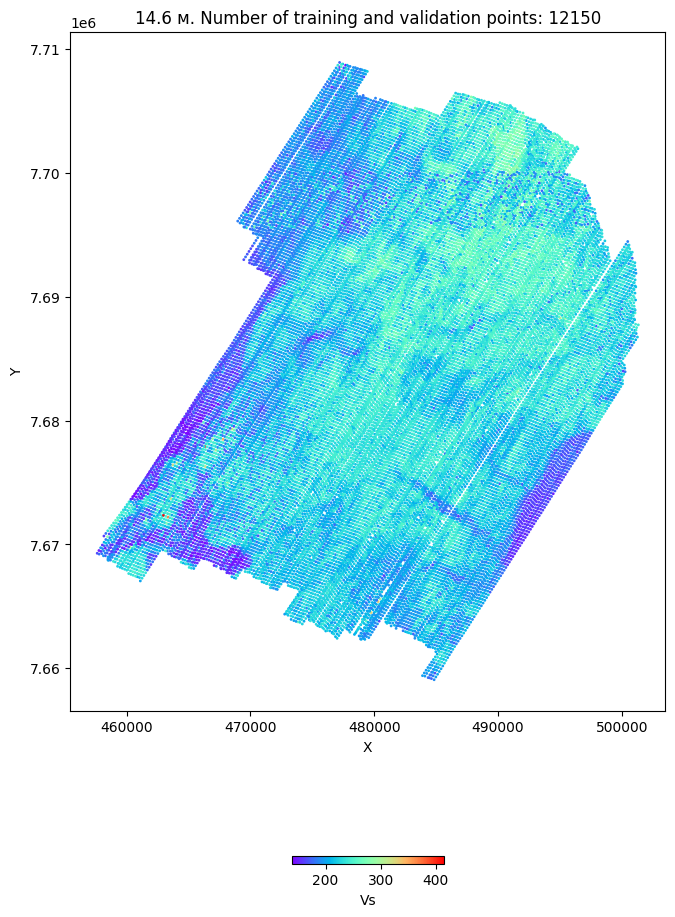

In [36]:
pred_map = plot_map(pred_slice, "14.6", X_train.shape[0], X_val.shape[0])
pred_map.plot()

In [38]:
train_dataset = SignalSpeedDataset(X_train, y_train[:, 2])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SignalSpeedDataset(X_val, y_val[:, 2])
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SignalSpeedDataset(X_test, y_test[:, 2])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model2 = CNNLSTMNetwork(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_kernel_size, stride=stride,
                        padding=padding, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout,
                        linear_input_size=linear_input_size, linear_output_size=linear_output_size,
                        input_shape=input_shape).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [39]:
with mlflow.start_run(run_name='third_depth') as run:
    params = {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": "ADAM",
        "in_channels": in_channels,
        'out_channels': out_channels,
        "conv_kernel_size": conv_kernel_size,
        'stride': stride,
        'padding': padding,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
        'linear_input_size': linear_input_size,
        'linear_output_size': linear_output_size,
        "input_shape": input_shape,
        'patience': patience,
        'min_delta': min_delta
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("../models/model_P_summary.txt", "w", encoding="utf-8") as f:
        f.write(str(summary(model2)))
    mlflow.log_artifact("../models/model_P_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        train(train_dataloader, model2, loss_fn, metric_fn, optimizer, epoch=t, device=device,
              output_size=linear_output_size)
        validation_loss, validation_mape = evaluate(val_dataloader, model2, loss_fn, metric_fn, epoch=t, device=device,
                                                    output_size=linear_output_size)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model2, "model")

Epoch 1
-------------------------------
loss: 45152.589844 MAPE: 1.000265 [0 / 346]
loss: 17948.267578 MAPE: 0.621388 [100 / 346]
loss: 825.979248 MAPE: 0.100121 [200 / 346]
loss: 934.131897 MAPE: 0.115531 [300 / 346]
Eval metrics: 
MAPE: 0.13, Avg loss: 755.215097 

Epoch 2
-------------------------------
loss: 803.149414 MAPE: 0.107333 [0 / 346]
loss: 705.408447 MAPE: 0.095251 [100 / 346]
loss: 1050.718384 MAPE: 0.114315 [200 / 346]
loss: 695.705627 MAPE: 0.113322 [300 / 346]
Eval metrics: 
MAPE: 0.13, Avg loss: 706.579929 

Epoch 3
-------------------------------
loss: 1355.292236 MAPE: 0.137596 [0 / 346]
loss: 1107.479004 MAPE: 0.139886 [100 / 346]
loss: 868.525146 MAPE: 0.110559 [200 / 346]
loss: 1567.267578 MAPE: 0.149639 [300 / 346]
Eval metrics: 
MAPE: 0.13, Avg loss: 764.871595 

Epoch 4
-------------------------------
loss: 1371.443481 MAPE: 0.146962 [0 / 346]
loss: 737.167236 MAPE: 0.101570 [100 / 346]
loss: 833.763062 MAPE: 0.111493 [200 / 346]
loss: 752.595459 MAPE: 0.1059

2024/07/27 18:22:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/07/27 18:22:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [40]:
true_slice = do_array_for_mapping(coord_train, coord_val, coord_test, y_train[:, 2], y_val[:, 2], y_test[:, 2])
y_pred = compute_y_pred(model0, test_dataloader, 'cuda')
pred_slice = do_array_for_mapping(coord_train, coord_val, coord_test, y_train[:, 2], y_val[:, 2], y_pred)

[]

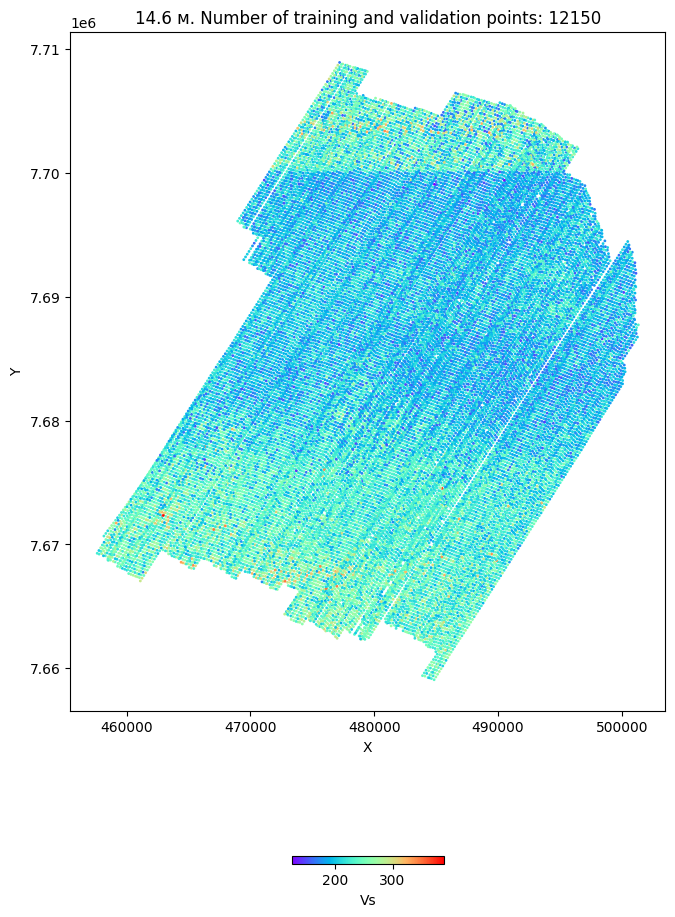

In [41]:
true_map = plot_map(true_slice, "14.6", X_train.shape[0], X_val.shape[0])
true_map.plot()

[]

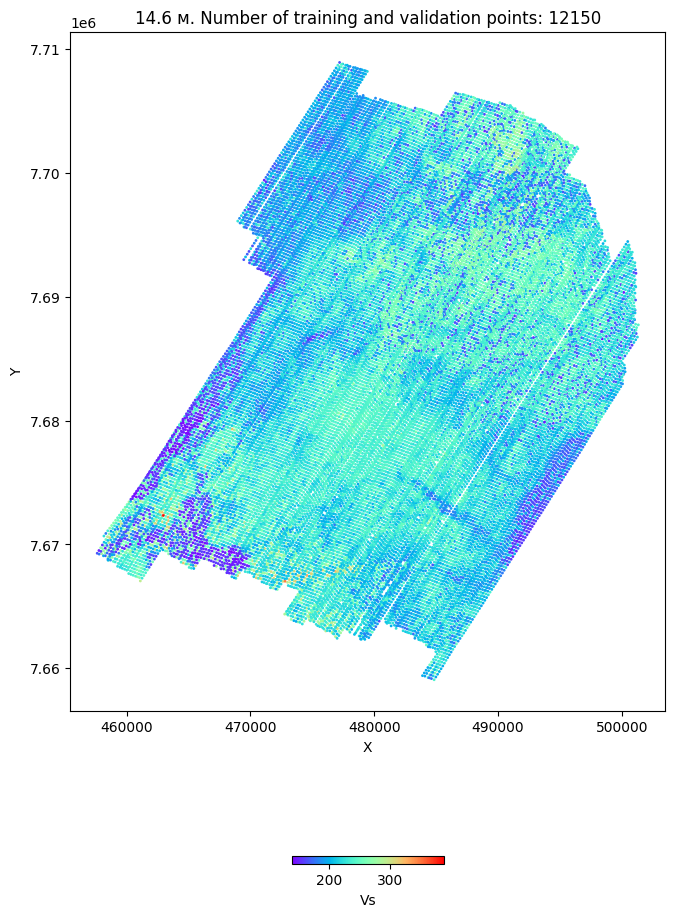

In [42]:
pred_map = plot_map(pred_slice, "14.6", X_train.shape[0], X_val.shape[0])
pred_map.plot()

In [43]:
train_dataset = SignalSpeedDataset(X_train, y_train[:, 3])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SignalSpeedDataset(X_val, y_val[:, 3])
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SignalSpeedDataset(X_test, y_test[:, 3])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model3 = CNNLSTMNetwork(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_kernel_size, stride=stride,
                        padding=padding, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout,
                        linear_input_size=linear_input_size, linear_output_size=linear_output_size,
                        input_shape=input_shape).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [44]:
with mlflow.start_run(run_name='fourth_depth') as run:
    params = {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": "ADAM",
        "in_channels": in_channels,
        'out_channels': out_channels,
        "conv_kernel_size": conv_kernel_size,
        'stride': stride,
        'padding': padding,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
        'linear_input_size': linear_input_size,
        'linear_output_size': linear_output_size,
        "input_shape": input_shape,
        'patience': patience,
        'min_delta': min_delta
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("../models/model_P_summary.txt", "w", encoding="utf-8") as f:
        f.write(str(summary(model3)))
    mlflow.log_artifact("../models/model_P_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        train(train_dataloader, model3, loss_fn, metric_fn, optimizer, epoch=t, device=device,
              output_size=linear_output_size)
        validation_loss, validation_mape = evaluate(val_dataloader, model3, loss_fn, metric_fn, epoch=t, device=device,
                                                    output_size=linear_output_size)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model3, "model")

Epoch 1
-------------------------------
loss: 66313.820312 MAPE: 0.999836 [0 / 346]
loss: 29244.126953 MAPE: 0.650290 [100 / 346]
loss: 4718.265625 MAPE: 0.187669 [200 / 346]
loss: 2498.013916 MAPE: 0.166348 [300 / 346]
Eval metrics: 
MAPE: 0.21, Avg loss: 2377.948891 

Epoch 2
-------------------------------
loss: 2423.409668 MAPE: 0.170105 [0 / 346]
loss: 3357.059082 MAPE: 0.203561 [100 / 346]
loss: 2553.119629 MAPE: 0.174424 [200 / 346]
loss: 2814.183838 MAPE: 0.161319 [300 / 346]
Eval metrics: 
MAPE: 0.21, Avg loss: 2401.860278 

Epoch 3
-------------------------------
loss: 3022.666504 MAPE: 0.176588 [0 / 346]
loss: 3306.934326 MAPE: 0.172331 [100 / 346]
loss: 4524.386230 MAPE: 0.179045 [200 / 346]
loss: 2453.365723 MAPE: 0.159104 [300 / 346]
Eval metrics: 
MAPE: 0.20, Avg loss: 2137.066103 

Epoch 4
-------------------------------
loss: 1489.598389 MAPE: 0.130017 [0 / 346]
loss: 1990.065430 MAPE: 0.149566 [100 / 346]
loss: 3239.958984 MAPE: 0.182082 [200 / 346]
loss: 3512.787354 

2024/07/27 18:30:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Eval metrics: 
MAPE: 0.13, Avg loss: 1152.846898 


2024/07/27 18:31:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [45]:
true_slice = do_array_for_mapping(coord_train, coord_val, coord_test, y_train[:, 2], y_val[:, 2], y_test[:, 2])
y_pred = compute_y_pred(model0, test_dataloader, 'cuda')
pred_slice = do_array_for_mapping(coord_train, coord_val, coord_test, y_train[:, 2], y_val[:, 2], y_pred)

[]

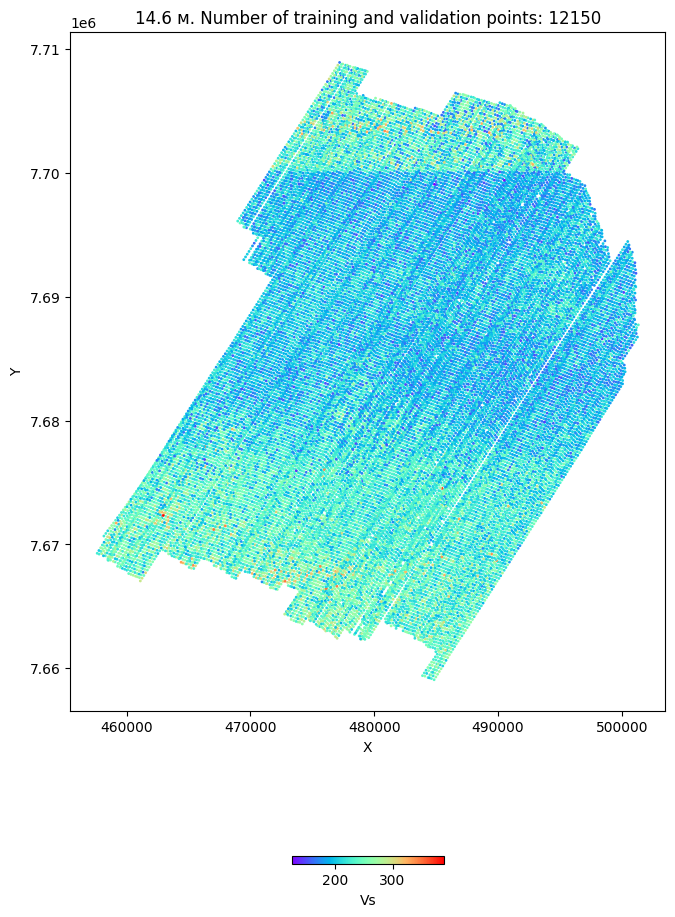

In [46]:
true_map = plot_map(true_slice, "14.6", X_train.shape[0], X_val.shape[0])
true_map.plot()

[]

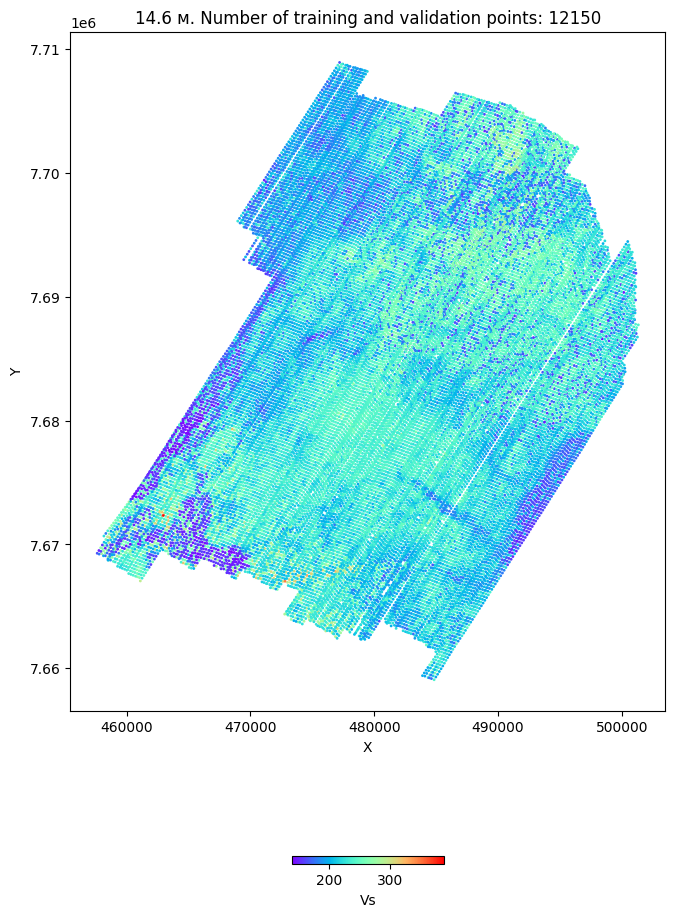

In [47]:
pred_map = plot_map(pred_slice, "14.6", X_train.shape[0], X_val.shape[0])
pred_map.plot()